# Objective

- Perform baseline imputation experiments and plot results as described in the publication (see README.md)

Note: Figure numbers correspond to the publication.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import geopandas as gpd
from shapely.geometry import Point
import rasterio as rio
from rasterio.plot import show

sns.set(font_scale=1.35, style='whitegrid')

# Read in processed precipitation timeseries and metadata

In [115]:
stations_path = '../data_processed/NRCS_dates_2008_2017.csv'
stations_df = pd.read_csv(stations_path)

Metadata = pd.read_csv('../data_processed/Metadata_processed.csv')
Metadata['StationID'] = Metadata['StationID'].apply(str)

display(stations_df)

,Date,Year,Month,Day,1030,317,1061,1041,1143,335,...,2132,2154,2158,2162,2139,0484,0761,2192,0951,0909
0,2008-01-01,2008,1,1,7.62,0.00,0.00,0.00,NaN,5.08,...,0.0,NaN,NaN,NaN,0.0,0.00,0.00,NaN,0.00,7.62
1,2008-01-02,2008,1,2,2.54,0.00,2.54,0.00,NaN,2.54,...,0.0,NaN,NaN,NaN,0.0,2.54,2.54,NaN,0.00,2.54
2,2008-01-03,2008,1,3,2.54,7.62,2.54,2.54,NaN,0.00,...,0.0,NaN,NaN,NaN,0.0,0.00,0.00,NaN,0.00,22.86
3,2008-01-04,2008,1,4,0.00,2.54,2.54,2.54,NaN,0.00,...,0.0,NaN,NaN,NaN,0.0,2.54,0.00,NaN,2.54,25.40
4,2008-01-05,2008,1,5,2.54,0.00,2.54,2.54,NaN,2.54,...,0.0,NaN,NaN,NaN,0.0,2.54,2.54,NaN,0.00,33.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2017-12-27,2017,12,27,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.00
3649,2017-12-28,2017,12,28,2.54,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,2.54,0.0,0.00,7.62
3650,2017-12-29,2017,12,29,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,25.40
3651,2017-12-30,2017,12,30,0.00,0.00,0.00,0.00,0.0,0.00,...,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,25.40


In [119]:
Metadata_gdf = gpd.GeoDataFrame(Metadata, geometry=[Point(xy) for xy in zip(Metadata['Longitude'], Metadata['Latitude'])])
Metadata_gdf.loc[:,'StationID'] = Metadata_gdf.loc[:,'StationID'].astype('int64')

In [120]:
Metadata_gdf

,StationID,Elevation,Latitude,Longitude,geometry
0,2138,6445,37.67455,-109.36429,POINT (-109.36429 37.67455)
1,1030,10960,40.35098,-106.38142,POINT (-106.38142 40.35098)
2,484,6240,41.03333,-107.65000,POINT (-107.65 41.03333)
3,317,7440,41.05413,-107.26609,POINT (-107.26609 41.05413)
4,1061,9080,40.06153,-107.00955,POINT (-107.00955 40.06153)
...,...,...,...,...,...
147,859,8950,41.00289,-106.90848,POINT (-106.90848 41.00289)
148,864,8641,39.96450,-110.98845,POINT (-110.98845 39.9645)
149,869,9540,40.34703,-106.09433,POINT (-106.09433 40.34703)
150,874,11000,37.47922,-106.80170,POINT (-106.8017 37.47922)


# Read files for plotting

In [96]:
UCWRR_path = '../data_raw/UCWRR_shapefile/HUC2_14.shp'
UCWRR_Boundary = gpd.read_file(UCWRR_path)
DEMraster_path = '../data_raw/UCWRR_DEM_800m.tif'

# Some functions

In [104]:
def segregate_stations(stations_df, output=True):

    incomplete_stations = stations_df.count() < 3653
    complete_stations = stations_df.count() == 3653

    start_col = 4 # first 4 columns are Date | Year | Month | Day

    number_incomplete_stations = sum(incomplete_stations[start_col:])
    number_complete_stations = sum(complete_stations[start_col:])
    if output == True:
        print (str(stations_df.shape[1]-start_col) + ' stations')
        print (str(number_complete_stations) + ' complete stations')
        print (str(number_incomplete_stations) + ' incomplete stations')

    Complete_df = stations_df.loc[:,complete_stations]
    Complete_df = Complete_df.iloc[:,start_col:]
    Incomplete_df = stations_df.loc[:,incomplete_stations]
    
    ## Final quality control by setting negative values to zero. There are a couple.
    Complete_df = Complete_df.mask(Complete_df < 0, 0.0)
    Incomplete_df = Incomplete_df.mask(Incomplete_df < 0, 0.0)
    
    return (Complete_df, Incomplete_df)

    
def get_NSE(labels, predictions):
    nse_num = mean_squared_error(labels, predictions)
    nse_den = mean_squared_error(labels, np.repeat(np.mean(labels), labels.shape[0]))
    nse = 1 - nse_num/nse_den
    return nse

def plot_results(rf, train_features, train_labels, test_features, test_labels):

    
###### Uncomment if plots of training data are desired ###
#     training_pred = rf.predict(train_features)    
#     train_NSE = get_NSE(train_labels, training_pred)

#     plt.scatter(train_labels, training_pred, s=5, alpha=0.7)
#     plt.xlabel('True Value (mm)')
#     plt.ylabel('Predicted Value (mm)')
#     plt.title('Precipitation: Training')
#     sns.set(font_scale=1.35, style='whitegrid') 
#     plot_end = np.max([training_pred, train_labels])
#     plt.plot([0, plot_end],[0, plot_end], '--')
#     plt.savefig('sampleImpute_training.png',dpi=300, bbox_inches='tight')
#     plt.show()

#     print ("Training correlation between prediction and true value: ")
#     print (np.corrcoef(training_pred, train_labels)[0,1])
#     print ("NSE (train): " + str(train_NSE))

############################################################

    predictions = rf.predict(test_features)
    nse_test = get_NSE(test_labels, predictions)
    
    fig, ax = plt.subplots()
    plt.scatter(test_labels, predictions, s=5, alpha=1)
    plt.xlabel('True Value (mm)')
    plt.ylabel('Predicted Value (mm)')
    plt.title('Precipitation: Testing')

    sns.set(font_scale=1.35, style='whitegrid')
    plot_end = np.max([test_labels, predictions])
    plot_end = 55
    plt.plot([0, plot_end],[0, plot_end], '--')
    
    textstr = "$NSE$ = " + str(round(nse_test,2))
    plt.title(textstr)

#     plt.savefig('sampleImpute_testing.png',dpi=300, bbox_inches='tight')
    plt.show()
    print ("NSE (test): " + str(nse_test))
    return

def train_rf(stationID, seed):
    labels = Complete_df.iloc[:,stationID]
    nstations = Complete_df.shape[1]
    features_indices = np.delete(np.arange(nstations), stationID)
    features = Complete_df.iloc[:,features_indices]

    features_array = np.asarray(features)
    labels_array = np.asarray(labels)
    train_indices, test_indices = train_test_split(np.arange(labels_array.shape[0]), test_size = 0.2, random_state = seed)
    train_features = features_array[train_indices,:]
    test_features = features_array[test_indices,:]
    train_labels = labels_array[train_indices]
    test_labels = labels_array[test_indices]
    
    rf = RandomForestRegressor(n_estimators = 100, min_samples_leaf=7, n_jobs=-1, max_features=int(features.shape[1]/2))

    rf.fit(train_features, train_labels)

    plot_results(rf, train_features, train_labels, test_features, test_labels)
    
    return (rf, features)


def get_mutual_corr(features, target, to_print = True):
    mutual_corr = [np.corrcoef(features[item], target)[0,1] for item in features.columns]
    
    features_corr = [(feature, round(information, 2)) for feature, information in zip(features.columns, mutual_corr)]
    features_corr = sorted(features_corr, key = lambda x: x[1], reverse = True)
    
    if to_print == True:
        [print('Variable: {:20} Mutual_Corr: {}'.format(*pair)) for pair in features_corr];
    return features_corr


### Segregate complete and incomplete records

In [97]:
Complete_df, Incomplete_df = segregate_stations(stations_df, False)

### Figure 1
Spatial extent of UCWRR, along with the layout of stations in the NRCS database (comprising of 97 complete and 55 incomplete records).

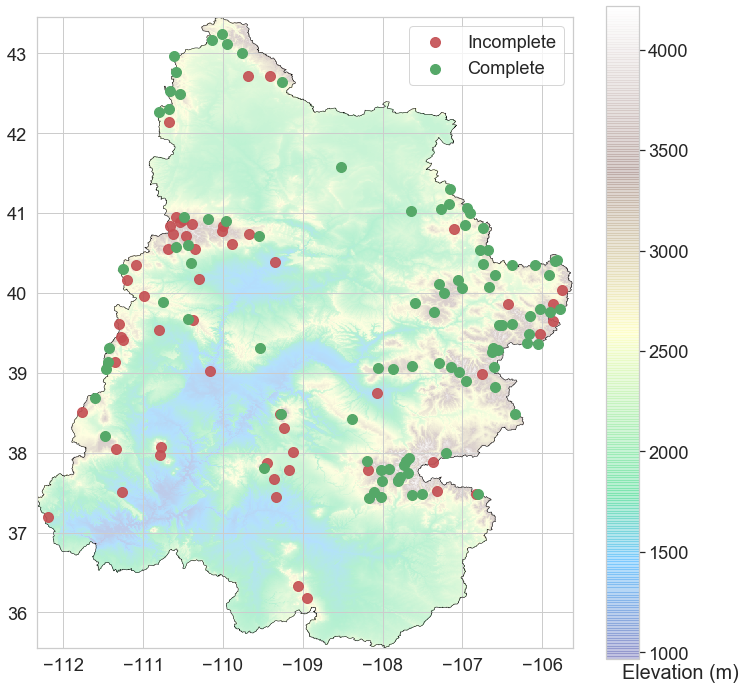

In [101]:
fig, ax = plt.subplots(figsize=(12,12))

src = rio.open(DEMraster_path)
plt.imshow(src.read(1, masked=True), cmap='terrain', alpha=0.3)
UCWRR_Boundary.plot(facecolor='none', ax=ax, edgecolor='black', linewidth=0.5)

Metadata_gdf[Metadata_gdf['StationID'].isin(Incomplete_df.columns)].plot(ax=ax, color='C3', alpha=0.9, markersize=100, label='Incomplete')
Metadata_gdf[Metadata_gdf['StationID'].isin(Complete_df.columns)].plot(ax=ax, color='C2', markersize=100, label='Complete')

show(src.read(1, masked=True), ax=ax, cmap='terrain', transform=src.transform, alpha=0.3)

cbar = plt.colorbar()
cbar.ax.set_xlabel('Elevation (m)', ha='left')

plt.legend()
sns.set(font_scale=1.65, style='whitegrid')

src.close()

# Baseline Runs

In [11]:
###### Lists of Performance metrics ####
corr_list = [] ## Correlation coefficient
nse_list = [] ## Nash-sutcliffe efficiency (NSE)
mae_list = [] ## Mean-absolute error
test_dry_err_list = [] ## Fraction of dry days that are correctly predicted (or PE/100)
nse_test_extreme_list=[] ## NSE for extreme events (daily precip greater than 95th percentile)
########################################

nstations= Complete_df.shape[1]


#### Specify seed ######
seed = 414 ## I picked 15 seeds with integer values between 400-414 (inclusive)
########################

for test_ind in np.arange(0,nstations):
    
    labels = Complete_df.iloc[:,test_ind]
    features_indices = np.delete(np.arange(nstations), test_ind)
    features = Complete_df.iloc[:,features_indices]
    features_array = np.asarray(features)
    labels_array = np.asarray(labels)    
    
    train_features, test_features, train_labels, test_labels = train_test_split(features_array, labels_array, test_size = 0.2, random_state = seed)

    rf_i = RandomForestRegressor(n_estimators = 100, min_samples_leaf=7,n_jobs=-1, max_features=int(features.shape[1]/2))
    rf_i.fit(train_features, train_labels)
    
    predictions = rf_i.predict(test_features)
    ## Mean absolute error
    mae_test = mean_absolute_error(test_labels, predictions)
    
    ## NSE values
    nse_test = get_NSE(test_labels, predictions)
    
    ## Fraction of dry days that are correctly predicted
    labels_df = pd.DataFrame({'labels':test_labels, 'predictions':predictions})
    labels_dry_df = labels_df[labels_df['labels'] <=2.54]
    number_dry_days = labels_dry_df.shape[0]
    number_dry_predictions = sum(labels_dry_df['predictions'] <=2.54)
    test_dry_err = (number_dry_days - number_dry_predictions)/number_dry_days
    
    ## NSE for extreme events
    Extreme_threshold = np.percentile(labels_array,95)
    labels_extreme_df = labels_df[labels_df['labels'] >=Extreme_threshold]
    nse_test_extreme = get_NSE(labels_extreme_df['labels'], labels_extreme_df['predictions'])
    
    ######## Append to lists of performance metrics
    corr_list.append(np.corrcoef(predictions, test_labels)[0,1])
    nse_list.append(nse_test)
    mae_list.append(mae_test)
    test_dry_err_list.append(test_dry_err)
    nse_test_extreme_list.append(nse_test_extreme)
    


In [12]:
Baseline_run = pd.DataFrame({"Stations":Complete_df.columns, "Test_corr":corr_list, "Test_NSE":nse_list, 
                             "Test_MAE":mae_list, "Test_dry_err":test_dry_err_list, 
                             "NSE_test_extreme":nse_test_extreme_list})

In [16]:
Baseline_run

,Stations,Test_corr,Test_NSE,Test_MAE,Test_dry_err,NSE_test_extreme
0,1030,0.868623,0.753083,1.519024,0.132509,-0.420007
1,317,0.815515,0.659136,1.260735,0.092834,-0.560353
2,1061,0.681779,0.464715,1.390080,0.111290,-0.571080
3,1041,0.884741,0.766624,1.103894,0.065359,0.146378
4,335,0.873222,0.746430,1.718438,0.176909,-0.280288
...,...,...,...,...,...,...
92,869,0.775130,0.600285,1.574443,0.121113,-0.315292
93,874,0.908168,0.795637,2.340815,0.181979,0.408350
94,2134,0.401286,0.097461,0.968608,0.058824,-3.567081
95,0484,0.803869,0.645985,2.052608,0.096834,-1.366940


### Save baseline run as csv (uncomment)

In [86]:
# Baseline_run.to_csv("../data_processed/Baseline_runs/Baseline_run_random_seed414.csv", index=False)

# Import all baseline runs (seeds 400-414)

These runs were generated using cell block "Baseline Runs" above.

In [48]:
rand1 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed400.csv")
rand2 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed401.csv")
rand3 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed402.csv")
rand4 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed403.csv")
rand5 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed404.csv")
rand6 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed405.csv")
rand7 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed406.csv")
rand8 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed407.csv")
rand9 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed408.csv")
rand10 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed409.csv")
rand11 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed410.csv")
rand12 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed411.csv")
rand13 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed412.csv")
rand14 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed413.csv")
rand15 = pd.read_csv("../data_processed/Baseline_runs/Baseline_run_random_seed414.csv")

In [49]:
NSE_df = rand1[["Stations", "Test_NSE"]]
NSE_df = pd.merge(NSE_df, rand2["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand3["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand4["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand5["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand6["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand7["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand8["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand9["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand10["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand11["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand12["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand13["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand14["Test_NSE"], left_index=True, right_index=True)
NSE_df = pd.merge(NSE_df, rand15["Test_NSE"], left_index=True, right_index=True)

NSE_df = NSE_df.drop(columns="Stations")

In [172]:
NSE_mean = pd.DataFrame({'Stations':rand1['Stations'], 'NSE (mean)': NSE_df.mean(axis=1), 'NSE (std)': NSE_df.std(axis=1)})

### Save NSE_mean (uncomment)

In [ ]:
# NSE_mean.to_csv("../data_processed/Baseline_runs/Baseline_runs_NSEmean.csv", index=False)

### Figure 5(a) 
Distribution of mean $NSE$ ($\mu_s$)

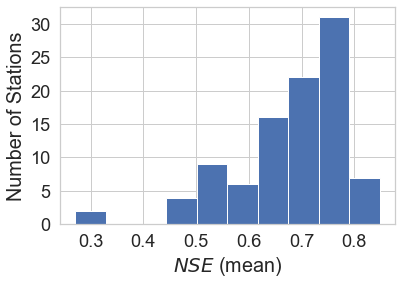

In [102]:
plt.hist(NSE_df.mean(axis=1))
plt.xlabel('$NSE$ (mean)')
plt.ylabel('Number of Stations')
sns.set(font_scale=1.35, style='whitegrid')
# plt.savefig('Baseline_run_NSE_mean_hist.png',dpi=300, bbox_inches='tight')

### Figure 5(b)
Scatter of mean ($\mu_s$) and standard deviation ($\sigma_s$) of $NSE$

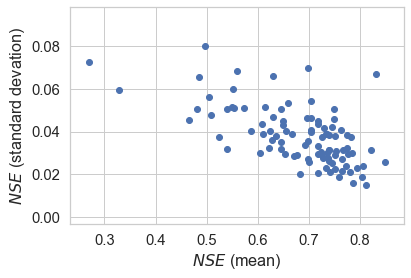

In [103]:
plt.scatter (NSE_df.mean(axis=1), NSE_df.std(axis=1))
plt.xlabel("$NSE$ (mean)")
plt.ylabel("$NSE$ (standard devation)")
sns.set(font_scale=1.35, style='whitegrid')
# plt.savefig('Baseline_run_NSE_mean_vs_sd.png',dpi=300, bbox_inches='tight')

### Figure 5(c)
Geospatial distribution of mean $NSE$ ($\mu_s$)

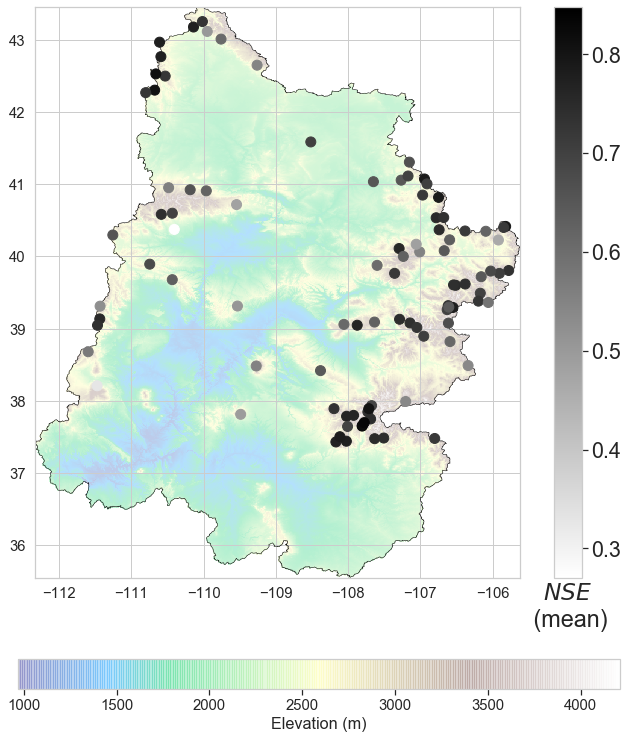

In [174]:
src = rio.open(DEMraster_path)

Metadata_gdf.loc[:,'StationID'] = Metadata_gdf.loc[:,'StationID'].astype('int64')
stations = pd.merge(NSE_mean, Metadata_gdf, left_on='Stations', right_on='StationID')


fig, ax = plt.subplots(figsize=(12,15))
plt.imshow(src.read(1, masked=True), cmap='terrain', alpha=0.3)
cbar1 = plt.colorbar(orientation="horizontal",fraction=0.2, shrink=0.9, pad=0.10)


cbar1.ax.set_xlabel('Elevation (m)', ha='center')

UCWRR_Boundary.plot(facecolor='none', ax=ax, edgecolor='black', linewidth=0.5)
plt.scatter(stations['Longitude'], stations['Latitude'], c=stations['NSE (mean)'], cmap='gray_r', s=100)
show(src.read(1, masked=True), ax=ax, cmap='terrain', transform=src.transform, alpha=0.3)
sns.set(font_scale=1.95, style='whitegrid')

cbar2 = plt.colorbar()
cbar2.ax.set_xlabel('$NSE$\n (mean)', ha='center')

# plt.savefig('Baseline_runs_NSE_spatial_dist.png',dpi=300, bbox_inches='tight')
plt.show()

src.close()

### Figure 6(a): Sample scatter plot for baseline imputations (High NSE example)

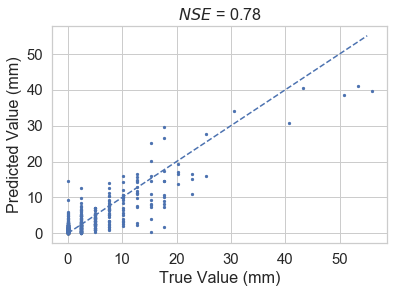

NSE (test): 0.7807287775009379


In [84]:
ID=8
(_, _) = train_rf(stationID=ID, seed=ID)

### Figure 6(b): Sample scatter plot for baseline imputations (Low NSE example)



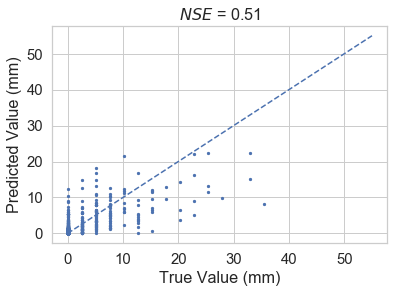

NSE (test): 0.5069021439179993


In [85]:
ID=76
(_, _) = train_rf(stationID=ID, seed=ID)

# Aggregate correlations between stations

In [105]:
mutual_corr_list = []

nstations= Complete_df.shape[1]


for test_ind in np.arange(0,nstations):
    
    labels = Complete_df.iloc[:,test_ind]
    features_indices = np.delete(np.arange(nstations), test_ind)
    features = Complete_df.iloc[:,features_indices]
    features_array = np.asarray(features)
    labels_array = np.asarray(labels)    
    
    
    mutual_corr = get_mutual_corr(features, labels, to_print = False)
    mutual_corr_list.append([item[1] for item in mutual_corr])


In [147]:
Mcorr_pd = pd.merge(NSE_mean, pd.DataFrame(mutual_corr_list), left_index=True, right_index=True)
Mcorr_S2 = pd.Series(np.sum(Mcorr_pd.iloc[:,2:4], axis=1))
Mcorr_S2.name = "Mcorr (S2)"

In [135]:
Mcorr_pd

,Stations,NSE (mean),0,1,2,3,4,5,6,7,...,86,87,88,89,90,91,92,93,94,95
0,1030,0.716909,0.73,0.72,0.72,0.70,0.70,0.68,0.66,0.65,...,0.29,0.28,0.28,0.27,0.24,0.23,0.23,0.21,0.21,0.19
1,317,0.650003,0.78,0.71,0.67,0.65,0.65,0.63,0.58,0.55,...,0.24,0.23,0.22,0.21,0.21,0.21,0.20,0.19,0.18,0.16
2,1061,0.550671,0.66,0.62,0.61,0.60,0.60,0.57,0.57,0.56,...,0.26,0.26,0.24,0.23,0.22,0.22,0.22,0.20,0.19,0.16
3,1041,0.749670,0.84,0.78,0.66,0.66,0.65,0.65,0.63,0.62,...,0.20,0.20,0.20,0.18,0.18,0.17,0.16,0.15,0.15,0.13
4,335,0.734107,0.79,0.71,0.70,0.69,0.69,0.68,0.68,0.67,...,0.20,0.19,0.18,0.18,0.18,0.18,0.17,0.17,0.16,0.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,869,0.621205,0.72,0.69,0.68,0.62,0.59,0.59,0.58,0.57,...,0.22,0.22,0.22,0.20,0.19,0.19,0.17,0.17,0.16,0.15
93,874,0.717296,0.78,0.78,0.76,0.74,0.72,0.72,0.72,0.71,...,0.19,0.19,0.17,0.16,0.15,0.14,0.13,0.13,0.12,0.10
94,2134,0.270583,0.48,0.48,0.45,0.44,0.43,0.35,0.34,0.33,...,0.11,0.11,0.11,0.11,0.10,0.10,0.09,0.09,0.09,0.05
95,484,0.652855,0.77,0.71,0.70,0.65,0.63,0.61,0.60,0.59,...,0.22,0.22,0.22,0.21,0.20,0.19,0.18,0.18,0.15,0.14


### Figure 7(a)

Text(0.75, 0.35, 'R = 0.95')

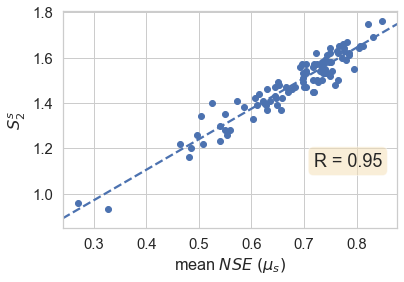

In [148]:
sns.set(font_scale=1.35, style='whitegrid')
fig, ax = plt.subplots()
textstr = "R = " + str(round(np.corrcoef(Mcorr_pd['NSE (mean)'], Mcorr_S2)[0,1],2)) 

sns.regplot(Mcorr_pd['NSE (mean)'], Mcorr_S2, ci=None, line_kws={'ls':'--'}, scatter_kws={'alpha':1})
plt.xlabel ("mean $NSE$ $(\mu_s)$")
plt.ylabel ("$S_2^s$")

props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.75, 0.35, textstr, transform=ax.transAxes, fontsize=18,
        verticalalignment='top', bbox=props)

### Figure 7(b)

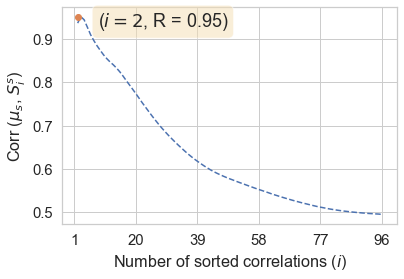

In [164]:
start=3
end=98
corr_with_mean = []

for i in np.arange(start,end):
    this_mean = np.sum(Mcorr_pd.iloc[:,2:i], axis=1)
    corr_with_mean.append (np.corrcoef(Mcorr_pd['NSE (mean)'], this_mean)[0,1])

plt.plot(np.arange(start,end)-1, corr_with_mean, '--')
plt.plot(2, corr_with_mean[1],'o')

# plt.xticks([1,40,96])
plt.xlabel('Number of sorted correlations ($i$)')
plt.ylabel('Corr ($\mu_s$, $S_i^s$)')
plt.xticks(np.linspace(1,96,6))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.annotate("($i=2$, R = 0.95)", (2, corr_with_mean[1]),textcoords="offset points",xytext=(20,-10),ha='left', fontsize=18, bbox=props)
# plt.savefig('Ground_Truth_rand_corr_NSE_Si.png',dpi=300, bbox_inches='tight')
plt.show()